In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
from torchvision.transforms import ToPILImage, RandomErasing, ColorJitter
from torchsummary import summary
from datetime import datetime
from millify import millify
import random
import scipy.stats as stats

In [ ]:
!unzip deep-learning-spring-2025-project-1.zip

Archive:  deep-learning-spring-2025-project-1.zip
  inflating: cifar-10-python/cifar-10-batches-py/batches.meta  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_1  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_2  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_3  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_4  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_5  
  inflating: cifar-10-python/cifar-10-batches-py/readme.html  
  inflating: cifar-10-python/cifar-10-batches-py/test_batch  
  inflating: cifar_test_nolabel.pkl  


In [2]:
# Path to the directory containing extracted CIFAR-10 batch files
DATA_PATH = './cifar-10-python/cifar-10-batches-py'

In [3]:
from os.path import isfile
for file in os.listdir(DATA_PATH):
    if isfile(os.path.join(DATA_PATH, file)):
        print(file)

data_batch_1
data_batch_2
batches.meta
test_batch
data_batch_3
data_batch_5
data_batch_4
readme.html


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
def load_batch(batch_file):
    with open(batch_file, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
    images = batch[b'data']
    labels = batch[b'labels']
    # Reshape to (N, 3, 32, 32) and scale pixel values to [0,1]
    images = images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    return images, labels

In [7]:
train_images = []
train_labels = []

for i in range(1, 6):
    batch_file = os.path.join(DATA_PATH, f'data_batch_{i}')
    images, labels = load_batch(batch_file)
    train_images.append(images)
    train_labels.extend(labels)

train_images = np.concatenate(train_images)
train_labels = np.array(train_labels)

print(f'Training data shape: {train_images.shape}, Training labels shape: {train_labels.shape}')

Training data shape: (50000, 3, 32, 32), Training labels shape: (50000,)


In [10]:
test_batch_file = os.path.join(DATA_PATH, 'test_batch')
test_images, test_labels = load_batch(test_batch_file)
print(f'Test data shape: {test_images.shape}')

Test data shape: (10000, 3, 32, 32)


In [12]:
train_images_tensor = torch.tensor(train_images)  # Shape: [N, 3, 32, 32]
test_images_tensor = torch.tensor(test_images)

# Compute mean and std per channel (dim=(0,2,3) aggregates over batch and spatial dims)
train_mean = train_images_tensor.mean(dim=(0, 2, 3)).tolist()
train_std = train_images_tensor.std(dim=(0, 2, 3)).tolist()

test_mean = test_images_tensor.mean(dim=(0, 2, 3)).tolist()
test_std = test_images_tensor.std(dim=(0, 2, 3)).tolist()

print(f"Training data distribution (mean={train_mean}, std={train_std})")
print(f"Test data distribution (mean={test_mean}, std={test_std})")

Training data distribution (mean=[0.491400808095932, 0.48215898871421814, 0.44653093814849854], std=[0.24703224003314972, 0.24348513782024384, 0.26158785820007324])
Test data distribution (mean=[0.49421426653862, 0.4851321876049042, 0.4504099488258362], std=[0.2466525286436081, 0.2428922802209854, 0.26159238815307617])


In [14]:
# Perform a KS test (Kolmogorov-Smirnov Test) to compare distributions
stat, p_value = stats.ks_2samp(train_images.flatten(), test_images.flatten())
print(f"KS Test Statistic: {stat}, P-value: {p_value}")

KS Test Statistic: 0.00503018880208328, P-value: 0.0


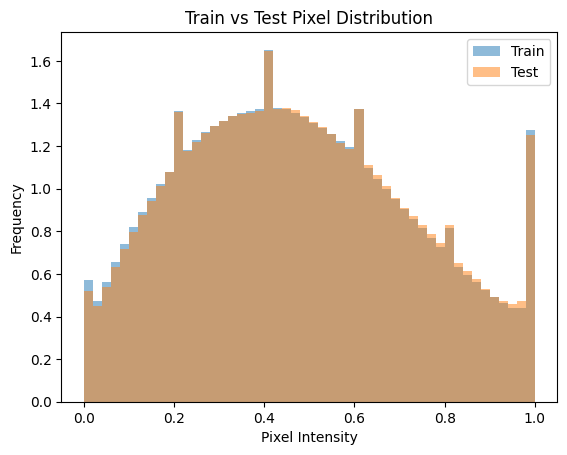

In [15]:
plt.hist(train_images.flatten(), bins=50, alpha=0.5, label="Train", density=True)
plt.hist(test_images.flatten(), bins=50, alpha=0.5, label="Test", density=True)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Train vs Test Pixel Distribution")
plt.show()

In [16]:
combined_images = np.concatenate((train_images, test_images), axis=0)
combined_labels = np.concatenate((train_labels, test_labels), axis=0)

print(f'Combined dataset shape: {combined_images.shape}, Combined labels shape: {combined_labels.shape}')

Combined dataset shape: (60000, 3, 32, 32), Combined labels shape: (60000,)


In [17]:
combined_images_tensor = torch.tensor(combined_images)  # Shape: [N, 3, 32, 32]

# Compute mean and std per channel (across batch and spatial dimensions)
combined_mean = combined_images_tensor.mean(dim=(0, 2, 3)).tolist()
combined_std = combined_images_tensor.std(dim=(0, 2, 3)).tolist()

print(f"Combined dataset distribution (mean={combined_mean}, std={combined_std})")

Combined dataset distribution (mean=[0.4918684661388397, 0.4826551079750061, 0.4471774399280548], std=[0.2469712197780609, 0.24338895082473755, 0.2615925967693329])


In [20]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.247, 0.243, 0.261]),
])

In [19]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.247, 0.243, 0.261]),
])

In [18]:
combined_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=combined_mean, std=combined_std),
])

In [76]:
unlabeled_combined_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=combined_mean,
                         std=combined_std),
])

In [21]:
class CIFARDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = torch.tensor(images).float()  # shape: (N,3,32,32)
        self.labels = torch.tensor(labels) if labels is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image (and label if available)
        image = self.images[idx]
        # If a transform is provided, convert to PIL image and apply it.
        if self.transform:
            image = ToPILImage()(image)
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        return image

In [47]:
# Use the entire training dataset for training
train_dataset = CIFARDataset(train_images, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

# Use the test dataset for validation
val_dataset = CIFARDataset(test_images, test_labels, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [12]:
test_dataset = CIFARDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [53]:
train_dataset = CIFARDataset(train_images, train_labels, transform=train_transform)

# Select 10% of the training data for validation
val_indices = torch.randperm(len(train_images))[:int(0.1 * len(train_images))]
val_dataset = Subset(train_dataset, val_indices)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

# Test dataset remains unchanged
test_dataset = CIFARDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [22]:
combined_train_dataset = CIFARDataset(combined_images, combined_labels, transform=combined_transform)

# Select 10% of the training data for validation
val_indices = torch.randperm(len(combined_images))[:int(0.1 * len(combined_images))]
val_dataset = Subset(combined_train_dataset, val_indices)

In [31]:
# Dataloaders
train_loader = DataLoader(combined_train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

# Test dataset remains unchanged
test_dataset = CIFARDataset(test_images, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [23]:
class ResidualBlockWithDropout(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.2):
        super(ResidualBlockWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_prob)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

In [74]:
class ModifiedResNetWithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.5):
        super(ModifiedResNetWithDropout, self).__init__()
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn        = nn.BatchNorm2d(64)
        self.relu      = nn.ReLU()
        self.layer1    = self._make_layer(64, 64, blocks=4, stride=1, dropout_prob=dropout_prob)
        self.layer2    = self._make_layer(64, 128, blocks=4, stride=2, dropout_prob=dropout_prob)
        self.layer3    = self._make_layer(128, 256, blocks=3, stride=2, dropout_prob=dropout_prob)
        self.avg_pool  = nn.AdaptiveAvgPool2d((1, 1))
        self.fc        = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride, dropout_prob):
        layers = [ResidualBlockWithDropout(in_channels, out_channels, stride, dropout_prob)]
        for _ in range(1, blocks):
            layers.append(ResidualBlockWithDropout(out_channels, out_channels, dropout_prob=dropout_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn(self.init_conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [75]:
model = ModifiedResNetWithDropout(num_classes=10, dropout_prob=0.5).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
ResidualBlockWithDropout-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        Dropout2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14           [-

In [26]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")
if total_params > 5e6:
    print("WARNING: Your model exceeds 5 million parameters!")

Total trainable parameters: 4700682


In [79]:
time = datetime.now().strftime("%d%m%Y%H%M")
params = millify(total_params, precision = 2)

In [80]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [81]:
def train_model(model, train_loader, val_loader, test_loader, epochs=100, lr=0.1, checkpoint_path=f'checkpoint-{params}-{time}.pth', resume=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    
    start_epoch = 0
    if resume and os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # continue from next epoch

    train_losses, val_accuracies, test_accuracies = [], [], []
    best_test_acc = 0.0  # Track highest test accuracy
    final_test_acc = 0.0
    final_train_loss = 0.0

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        val_acc = evaluate(model, val_loader)
        val_accuracies.append(val_acc)

        test_acc = evaluate(model, test_loader)
        test_accuracies.append(test_acc)

        # Track highest test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f} - Test Acc: {test_acc:.4f}")

        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_loss
        }
        torch.save(checkpoint, checkpoint_path)

    # Store final metrics
    final_train_loss = train_losses[-1]  # Last training loss
    final_test_acc = test_accuracies[-1]  # Last test accuracy

    return train_losses, val_accuracies, test_accuracies, final_test_acc, final_train_loss, best_test_acc

In [86]:
train_losses, val_accuracies, test_accuracies, final_test_acc, final_train_loss, best_test_acc = train_model(model, train_loader, val_loader, test_loader, epochs=100, lr=0.1, resume=False)

Epoch 1/100 - Loss: 2.0022 - Val Acc: 0.3595 - Test Acc: 0.3658
Epoch 2/100 - Loss: 1.6162 - Val Acc: 0.4845 - Test Acc: 0.4897
Epoch 3/100 - Loss: 1.3833 - Val Acc: 0.5223 - Test Acc: 0.5304
Epoch 4/100 - Loss: 1.1850 - Val Acc: 0.6227 - Test Acc: 0.6326
Epoch 5/100 - Loss: 1.0635 - Val Acc: 0.6097 - Test Acc: 0.6118
Epoch 6/100 - Loss: 0.9841 - Val Acc: 0.6658 - Test Acc: 0.6577
Epoch 7/100 - Loss: 0.9382 - Val Acc: 0.6597 - Test Acc: 0.6771
Epoch 8/100 - Loss: 0.8955 - Val Acc: 0.6878 - Test Acc: 0.7066
Epoch 9/100 - Loss: 0.8557 - Val Acc: 0.7360 - Test Acc: 0.7468
Epoch 10/100 - Loss: 0.8129 - Val Acc: 0.7377 - Test Acc: 0.7445
Epoch 11/100 - Loss: 0.7847 - Val Acc: 0.7653 - Test Acc: 0.7838
Epoch 12/100 - Loss: 0.7436 - Val Acc: 0.7600 - Test Acc: 0.7708
Epoch 13/100 - Loss: 0.7212 - Val Acc: 0.7932 - Test Acc: 0.8013
Epoch 14/100 - Loss: 0.7039 - Val Acc: 0.7982 - Test Acc: 0.8067
Epoch 15/100 - Loss: 0.6823 - Val Acc: 0.7340 - Test Acc: 0.7479
Epoch 16/100 - Loss: 0.6734 - Val 

In [87]:
print(f"Final Test Accuracy: {final_test_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Highest Test Accuracy Achieved: {best_test_acc:.4f}")

Final Test Accuracy: 0.9906
Final Training Loss: 0.1044
Highest Test Accuracy Achieved: 0.9906


In [88]:
save_model_name = f"modified-resnet-cifar10-{params}-{time}.pth"
torch.save(model.state_dict(), save_model_name)

In [89]:
def plot_metrics(train_losses, val_accuracies, test_accuracies):
    epochs = len(train_losses)
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(15, 5))

    # Plot Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", color="green", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, test_accuracies, label="Test Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

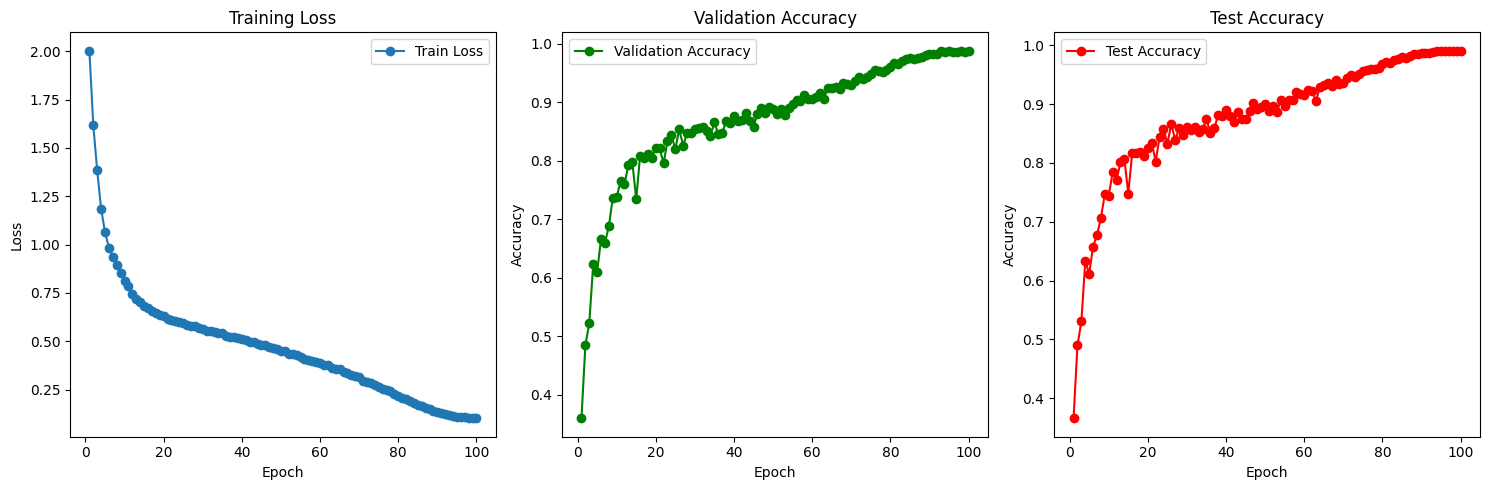

In [90]:
plot_metrics(train_losses, val_accuracies, test_accuracies)

In [91]:
class CIFARTestNoLabelDataset(Dataset):
    def __init__(self, pickle_file, transform=None):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f, encoding='bytes')
        # raw_data is in shape (N, 32, 32, 3)
        raw_data = data[b'data']
        # Transpose to (N, 3, 32, 32) and scale to [0,1]
        self.images = raw_data.transpose(0, 3, 1, 2).astype(np.float32) / 255.0

        # Optionally use provided IDs, otherwise we'll default to indices
        self.ids = data.get(b'ids', None)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]).float()
        if self.transform:
            image = ToPILImage()(image)
            image = self.transform(image)
        # Use the id from the file if available, otherwise use the index.
        if self.ids is not None:
            # Assuming ids are stored as a list of bytes or strings.
            id_val = self.ids[idx]
            # Convert bytes to string if necessary
            if isinstance(id_val, bytes):
                id_val = id_val.decode('utf-8')
        else:
            id_val = idx
        return image, id_val

In [92]:
unlabeled_test_dataset = CIFARTestNoLabelDataset('cifar_test_nolabel.pkl', transform=unlabeled_combined_transform)
unlabeled_test_loader = DataLoader(unlabeled_test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [93]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [94]:
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)

In [95]:
def unnormalize(tensor):
    """Unnormalizes a batch of images"""
    return tensor * std.to(tensor.device) + mean.to(tensor.device)

In [96]:
def show_test_predictions(model, test_dataset, class_names, num_images=8):
    model.eval()

    # Randomly select `num_images` images from the dataset
    indices = random.sample(range(len(test_dataset)), num_images)
    images, labels = zip(*[test_dataset[i] for i in indices])  # Extract images and labels
    
    images_tensor = torch.stack(images).to(device)  # Convert list to tensor and move to GPU
    labels_tensor = torch.tensor(labels).to(device)  # Convert labels to tensor and move to GPU

    with torch.no_grad():
        outputs = model(images_tensor)
        _, predicted_labels = torch.max(outputs, 1)

    # Unnormalize images for correct visualization
    unnormalized_images = unnormalize(images_tensor).cpu().clamp(0, 1)  # Ensure values are in [0,1]
    
    # Convert images back to NumPy for visualization
    images_np = [transforms.ToPILImage()(img) for img in unnormalized_images]

    # Display images with predictions and actual labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    for i in range(num_images):
        axes[i].imshow(images_np[i])
        axes[i].axis("off")

        actual = class_names[labels_tensor[i].item()]
        predicted = class_names[predicted_labels[i].item()]
        
        # Color title green if correct, red otherwise
        color = "green" if actual == predicted else "red"
        axes[i].set_title(f"Pred: {predicted}\nActual: {actual}", color=color)

    plt.show()

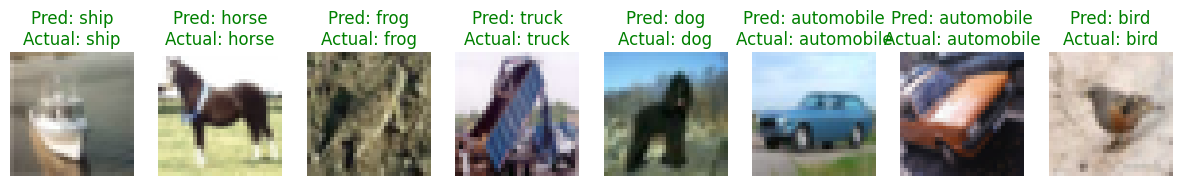

In [97]:
show_test_predictions(model, test_dataset, class_names)

In [98]:
def show_unlabeled_predictions(model, unlabeled_dataset, class_names, num_images=10):
    model.eval()

    # Randomly select `num_images` indices
    indices = random.sample(range(len(unlabeled_dataset)), num_images)
    
    # Extract images (handle tuple dataset case)
    images = [unlabeled_dataset[i][0] if isinstance(unlabeled_dataset[i], tuple) else unlabeled_dataset[i] for i in indices]

    images_tensor = torch.stack(images).to(device)  # Convert list to tensor and move to GPU

    with torch.no_grad():
        outputs = model(images_tensor)
        _, predicted_labels = torch.max(outputs, 1)

    # Unnormalize images for correct visualization
    unnormalized_images = unnormalize(images_tensor).cpu().clamp(0, 1)  # Ensure values are in [0,1]
    
    # Convert images back to NumPy for visualization
    images_np = [transforms.ToPILImage()(img) for img in unnormalized_images]

    # Display images with predictions
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    for i in range(num_images):
        axes[i].imshow(images_np[i])
        axes[i].axis("off")

        predicted = class_names[predicted_labels[i].item()]
        axes[i].set_title(f"Pred: {predicted}", color="blue")  # Blue color for predictions

    plt.show()

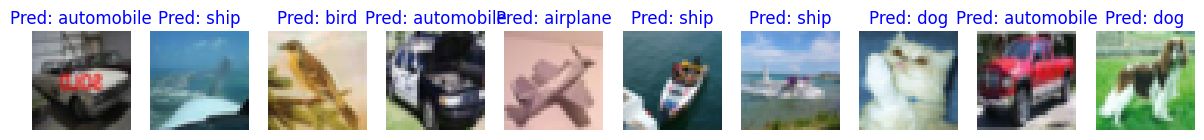

In [99]:
show_unlabeled_predictions(model, unlabeled_test_dataset, class_names)

In [100]:
def generate_submission(model, test_loader):
    filename = f"submission-{params}-{time}.csv"
    model.eval()
    ids = []
    preds = []

    with torch.no_grad():
        for images, idxs in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Convert tensors to plain integers
            ids.extend([int(i) for i in idxs])
            preds.extend([int(p) for p in predicted])

    submission_df = pd.DataFrame({"ID": ids, "Labels": preds})
    submission_df.to_csv(filename, index=False)
    print(f"Submission saved to {filename}!")

In [101]:
generate_submission(model, unlabeled_test_loader)

Submission saved to submission-4.7M-110320252239.csv!
